In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from bs4 import BeautifulSoup
import datetime
sns.set()
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Loading simpsons data in (https://www.kaggle.com/wcukierski/the-simpsons-by-the-data) and create a sql database

In [4]:
characters = pd.read_csv("simpsons_characters.csv")
characters.head(3)

,id,name,normalized_name,gender
0,7,Children,children,NaN
1,12,Mechanical Santa,mechanical santa,NaN
2,13,Tattoo Man,tattoo man,NaN


Characters table included in ofmraiton on the name and gender of the characters

In [5]:
episodes = pd.read_csv("simpsons_episodes.csv")
episodes.head(3)

,id,title,original_air_date,production_code,season,number_in_season,number_in_series,us_viewers_in_millions,views,imdb_rating,imdb_votes,image_url,video_url
0,10,Homer's Night Out,1990-03-25,7G10,1,10,10,30.3,50816.0,7.4,1511.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/275197507879
1,12,Krusty Gets Busted,1990-04-29,7G12,1,12,12,30.4,62561.0,8.3,1716.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/288019523914
2,14,"Bart Gets an ""F""",1990-10-11,7F03,2,1,14,33.6,59575.0,8.2,1638.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/260539459671


Episodes table included information on title of the episode, viewership, imdb_ratings, links to the images and videos, and original air date.

In [6]:
locations = pd.read_csv("simpsons_locations.csv")
locations.head(3)

,id,name,normalized_name
0,1,Street,street
1,2,Car,car
2,3,Springfield Elementary School,springfield elementary school


Location table included information the location of where the scenes were set at.

In [54]:
script = pd.read_csv("simpsons_script_lines.csv",error_bad_lines=False)
# line 8084, 52607, 59910, 71801, 73539, 77230, 78953, 81138, 101154, 115438, 117573, 130610, 152970, 153017, 153018, 
# 154080, 154082, 154084, 154086, 154089, 154165, 156872 were skipped due to errors
script.head(2)

b'Skipping line 8084: expected 13 fields, saw 20\nSkipping line 52607: expected 13 fields, saw 21\nSkipping line 59910: expected 13 fields, saw 21\n'
b'Skipping line 71801: expected 13 fields, saw 20\nSkipping line 73539: expected 13 fields, saw 21\nSkipping line 77230: expected 13 fields, saw 21\nSkipping line 78953: expected 13 fields, saw 21\nSkipping line 81138: expected 13 fields, saw 20\nSkipping line 86746: expected 13 fields, saw 22\nSkipping line 101154: expected 13 fields, saw 21\nSkipping line 115438: expected 13 fields, saw 20\nSkipping line 117573: expected 13 fields, saw 22\nSkipping line 130610: expected 13 fields, saw 22\n'
b'Skipping line 152970: expected 13 fields, saw 22\nSkipping line 153017: expected 13 fields, saw 20\nSkipping line 153018: expected 13 fields, saw 30\nSkipping line 154080: expected 13 fields, saw 20\nSkipping line 154082: expected 13 fields, saw 20\nSkipping line 154084: expected 13 fields, saw 20\nSkipping line 154086: expected 13 fields, saw 20\n

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0


The script table has some rows that were entered incorrectly. I attempted manually edit some of them, but it seems that some data points were missing.
The script table included raw_text, whether it's a speaking line or not, the character, location, and word count.

In [55]:
# creating a connection to sql database, simpsons.sqlite
conn = sqlite3.connect("simpsons.sqlite")

In [56]:
characters.to_sql("characters", conn, index = False,if_exists = "replace")
episodes.to_sql("episodes", conn, index = False, if_exists = "replace")
locations.to_sql("locations", conn, index = False, if_exists = "replace")
script.to_sql("script", conn, index = False, if_exists = "replace")

In [57]:
pd.read_sql_query("""SELECT *
                     FROM episodes
                     LIMIT 1""",conn)

,id,title,original_air_date,production_code,season,number_in_season,number_in_series,us_viewers_in_millions,views,imdb_rating,imdb_votes,image_url,video_url
0,10,Homer's Night Out,1990-03-25,7G10,1,10,10,30.3,50816.0,7.4,1511.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/275197507879


In [58]:
pd.read_sql_query("""SELECT MAX(CAST (original_air_date AS DATE)),
                            MIN(CAST (original_air_date AS DATE))
                     FROM episodes""",conn)

,MAX(CAST (original_air_date AS DATE)),MIN(CAST (original_air_date AS DATE))
0,2016,1989


In [59]:
pd.read_sql_query("""SELECT MAX(season) AS "Total Seasons", 
                            MAX(number_in_season) AS "Max No. of Episodes in One Season", 
                            MAX(number_in_series) AS "Totoal No. of Episodes",
                            MIN(us_viewers_in_millions) AS "Min US Viewers in Millions for one episode",
                            MAX(us_viewers_in_millions) AS "Max US viewers in Millions for one episode",
                            ROUND(AVG(us_viewers_in_millions),2) AS "Average Number of Viewers in Millions",
                            MAX(imdb_rating) AS "Max imdb Rating",
                            MIN(imdb_rating) AS "Min imdb Rating",
                            ROUND(AVG(imdb_rating),2) AS "Avg imdb Rating",
                            ROUND(AVG(imdb_votes),2) AS "Avg imdb votes"
                     FROM episodes;""", conn)

,Total Seasons,Max No. of Episodes in One Season,Totoal No. of Episodes,Min US Viewers in Millions for one episode,Max US viewers in Millions for one episode,Average Number of Viewers in Millions,Max imdb Rating,Min imdb Rating,Avg imdb Rating,Avg imdb votes
0,28,25,600,2.32,33.6,11.84,9.2,4.5,7.39,832.37


The dataset included a total of 28 seasons and 600 episodes (from 1989 to 2016). The number of US viewers in million ranged from 2.32 to 33.6 with an average of 11.84 million viewers. The range of imdb ratings went from 4.5 to 9.2 with an average rating of 7.39 and rated by an average of 832 individuals. There were only 4 episodes included from season 28.

In [60]:
graphing = pd.read_sql_query("""SELECT season,
                            MAX(number_in_season) AS "episodes",
                            MAX(us_viewers_in_millions) AS "viewer_high",
                            MIN(us_viewers_in_millions) AS "viewer_low",
                            AVG(us_viewers_in_millions) AS "viewer_avg",
                            MAX(imdb_rating) AS "imdb_max_rating",
                            MIN(imdb_rating) AS "imdb_min_rating",
                            AVG(imdb_rating) AS "imdb_avg_rating",
                            AVG(imdb_votes) AS "avg_voters"
                     FROM episodes
                     WHERE season < 28
                     GROUP BY season""", conn)
# season 28 was excluded cause it was only four episodes in the dataset

In [61]:
pd.read_sql_query("""SELECT MAX(number_in_series)/MAX(season) AS "avg_episodes_season"
                     FROM episodes
                     WHERE season < 28""", conn)

,avg_episodes_season
0,22


In [62]:
graph_viewer = pd.melt(graphing, id_vars=['season'], value_vars=['viewer_high', 'viewer_low','viewer_avg'])

In [63]:
graph_viewer.head(3)

,season,variable,value
0,1,viewer_high,33.5
1,2,viewer_high,33.6
2,3,viewer_high,25.5


In [64]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

In [65]:
graph_rating = pd.melt(graphing, id_vars = ['season'], value_vars = ['imdb_max_rating','imdb_min_rating','imdb_avg_rating'])

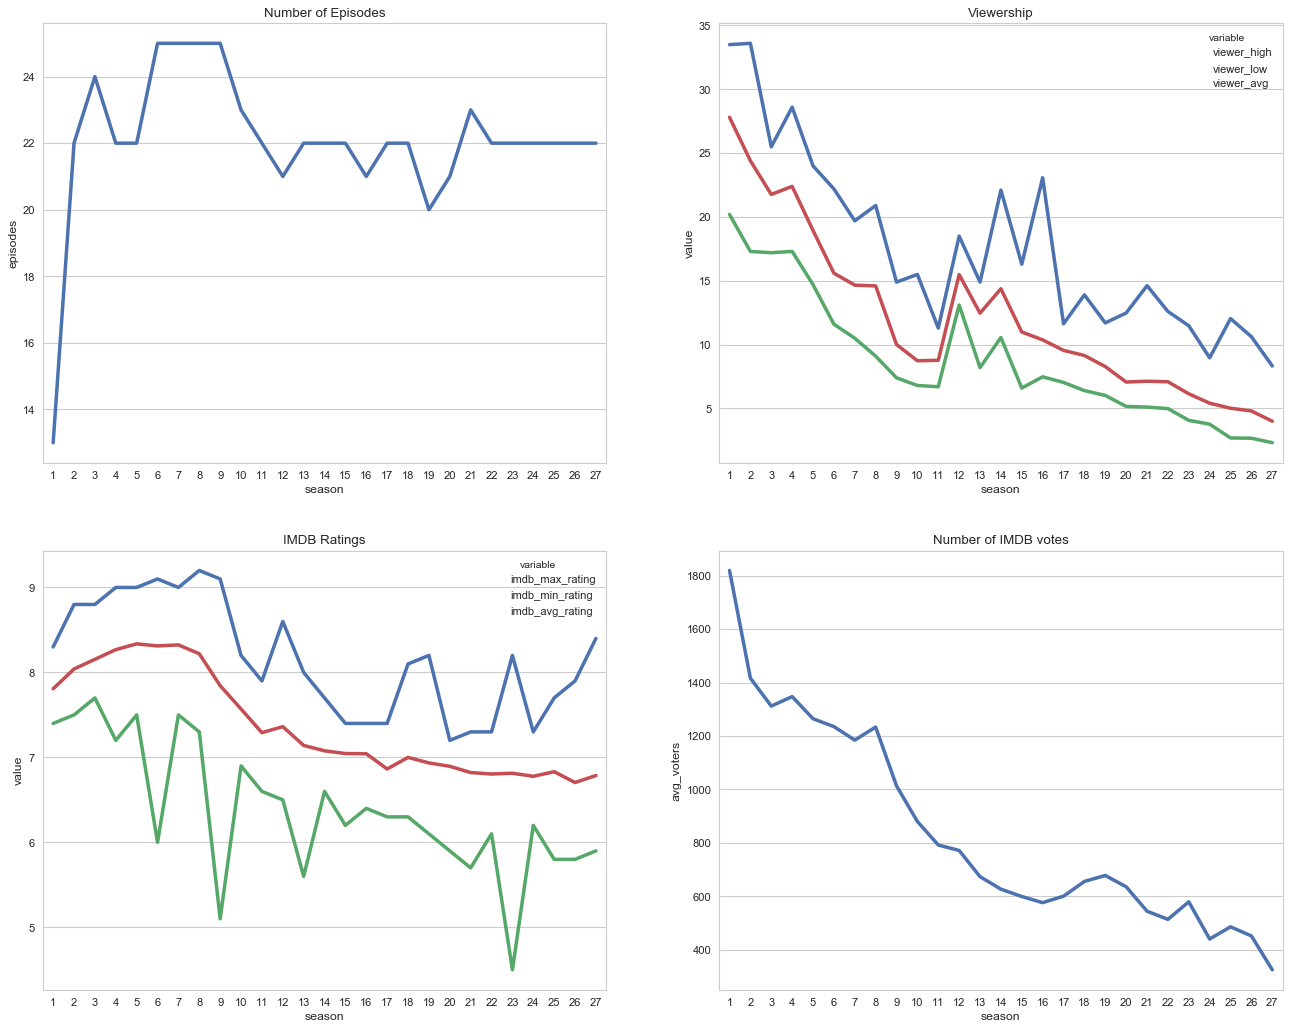

In [66]:
plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,2,1)
sns.pointplot(x = "season", y = "episodes", data = graphing, markers="")
plt.title("Number of Episodes")
plt.subplot(2,2,2)
sns.pointplot(x = "season", y = "value", data = graph_viewer, hue = "variable", markers="")
plt.title("Viewership")
plt.subplot(2,2,3)
sns.pointplot(x = "season", y = "value", data = graph_rating, hue = "variable", markers="")
plt.title("IMDB Ratings")
plt.subplot(2,2,4)
sns.pointplot(x = "season", y = "avg_voters", data = graphing, markers="")
plt.title("Number of IMDB votes")
plt.show()

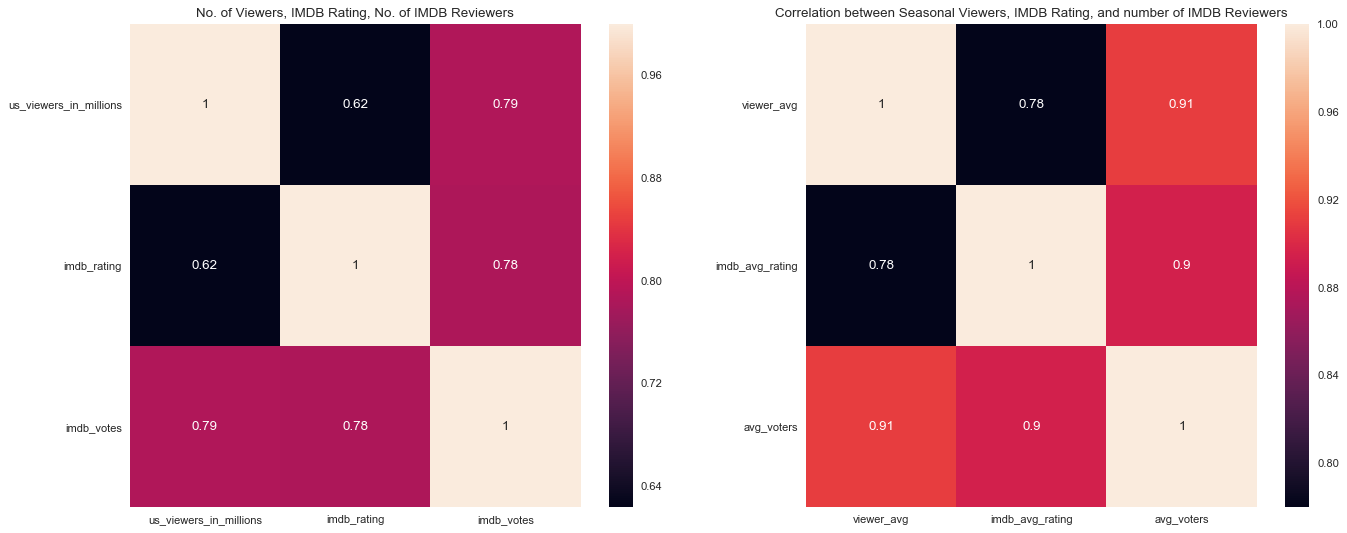

In [67]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
sns.heatmap(episodes[["us_viewers_in_millions", "imdb_rating","imdb_votes"]].corr(), annot= True)
plt.title("No. of Viewers, IMDB Rating, No. of IMDB Reviewers")
plt.yticks(rotation=0)
plt.subplot(1,2,2)
sns.heatmap(graphing[["viewer_avg","imdb_avg_rating","avg_voters"]].corr(), annot= True)
plt.title("Correlation between Seasonal Viewers, IMDB Rating, and number of IMDB Reviewers")
plt.yticks(rotation=0)
plt.show()

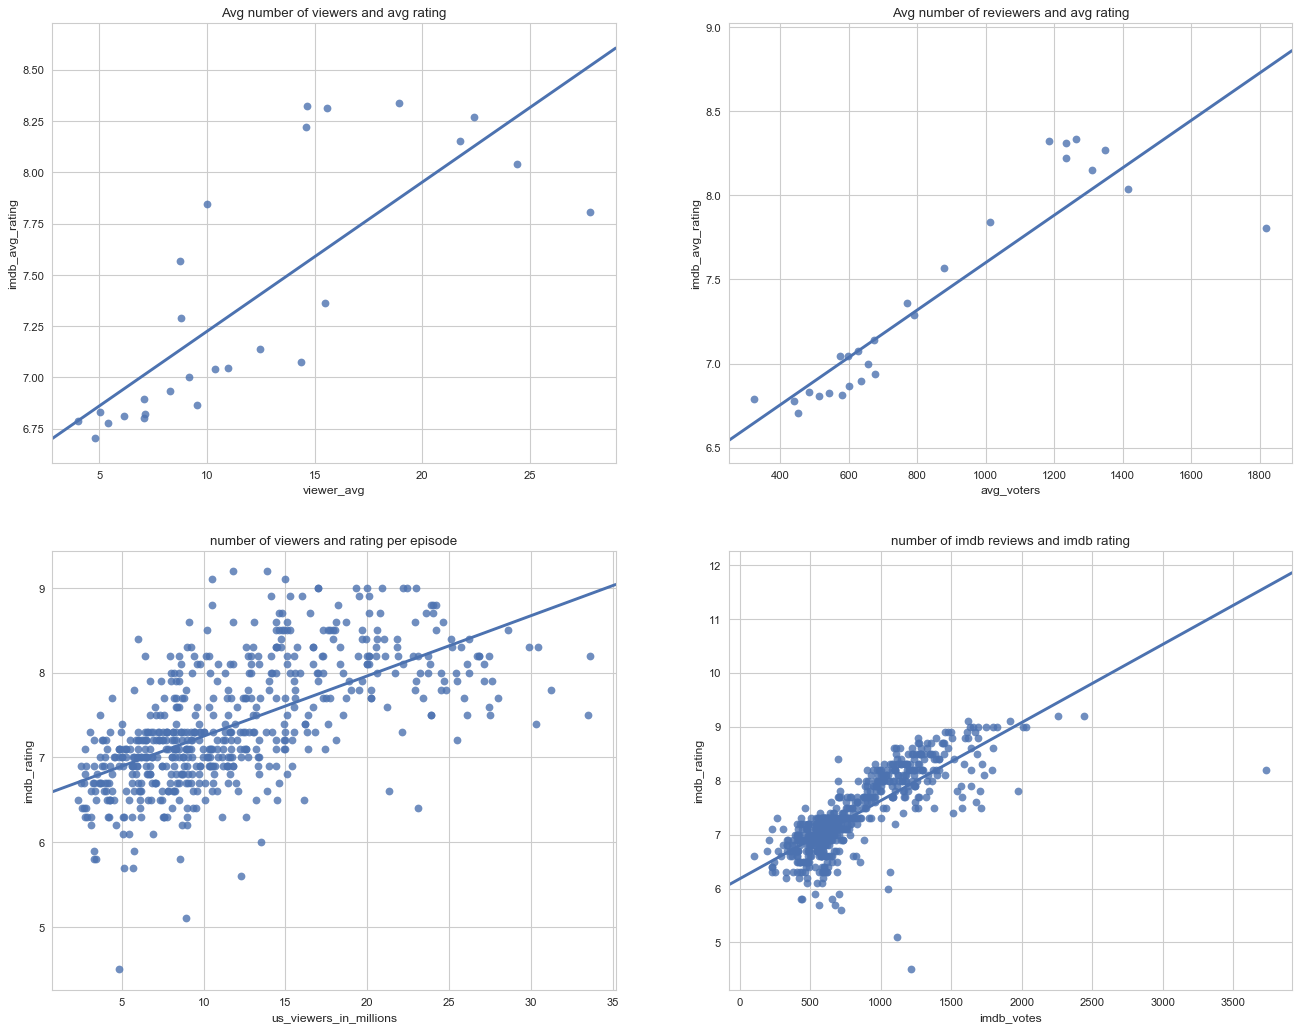

In [68]:
plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,2,1)
sns.regplot(x = "viewer_avg", y = "imdb_avg_rating", data = graphing, ci=False)
plt.title("Avg number of viewers and avg rating")
plt.subplot(2,2,2)
sns.regplot(x = "avg_voters", y = "imdb_avg_rating", data = graphing, ci=False)
plt.title("Avg number of reviewers and avg rating")
plt.subplot(2,2,3)
sns.regplot(x = "us_viewers_in_millions", y = "imdb_rating", data = episodes, ci= False)
plt.title("number of viewers and rating per episode")
plt.subplot(2,2,4)
sns.regplot(x = "imdb_votes", y = "imdb_rating", data = episodes, ci = False)
plt.title("number of imdb reviews and imdb rating")
plt.show()

In [69]:
# Low correlation between number of episodes and avg_rating
graphing[["episodes","imdb_avg_rating"]].corr()

,episodes,imdb_avg_rating
episodes,1.000000,0.247886
imdb_avg_rating,0.247886,1.000000


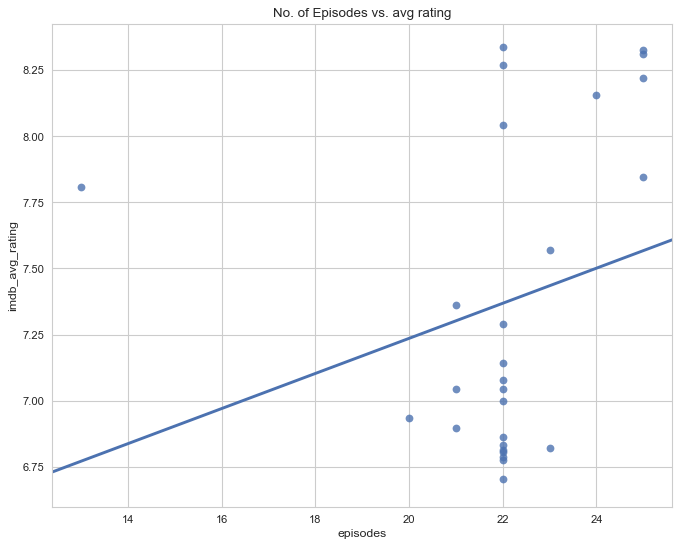

In [70]:
plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
sns.regplot(x = "episodes", y = "imdb_avg_rating", data = graphing, ci=False)
plt.title("No. of Episodes vs. avg rating")
plt.show()

1. The number of episodes spiked after the first season (13 episodes), and reached the height from season 6 to 9 (25 episodes). The latest seasons all had about 22 episodes (avg 22). 
2. The number of viewers had been decreasing steadily after the first season. While the ovhaerall viewership was decreasing, there were some episodes in the following seasons that attracted large numbers of viewers. 
3. Average IMDB rating gradually increased from season one to about season 6, and had been on a downward trend since. 
4. The number of reviewers for the season had also been decreasing on IMDB
5. The average number of viewers and average numbers of reviews on imdb is positively correlated to the ratings.
6. The seasonal rating is not related to the number of episodes in each season.

In [71]:
date = pd.read_sql_query("""SELECT original_air_date, 
                                   title,
                                   season
                            FROM episodes""", conn)

In [72]:
date["original_air_date"] = pd.to_datetime(date["original_air_date"], format = "%Y-%m-%d")

In [73]:
date["weekday"] = date["original_air_date"].dt.weekday

In [74]:
date["weekday"].value_counts()
# 0 monday and 6 sunday

6    506
3     89
2      2
1      2
4      1
Name: weekday, dtype: int64

In [75]:
air_date = pd.pivot_table(date, values = "original_air_date", index = "season", columns="weekday", aggfunc = "count")

In [76]:
air_date[0] = 0
air_date[5] = 0

In [77]:
air_date_graph = air_date[[0,1,2,3,4,5,6]]
air_date_graph = air_date_graph.rename(columns = {0:"Monday",1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4: "Friday", 5: "Saturday", 6:"Sunday"})
air_date_graph = air_date_graph.fillna(0)

In [78]:
plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

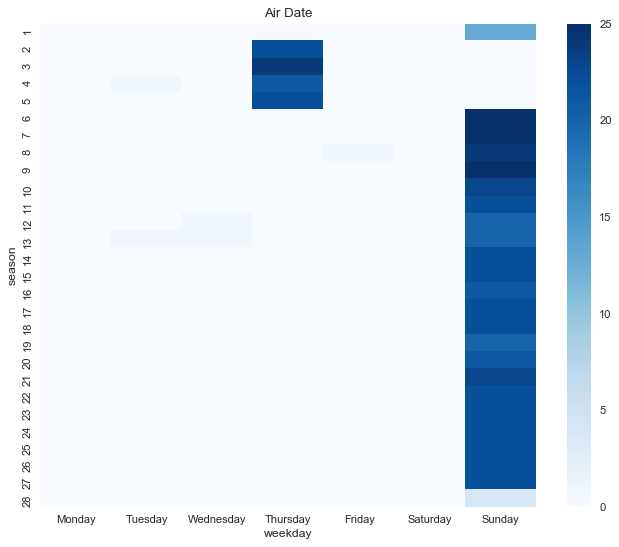

In [79]:
sns.set_style("whitegrid")
sns.heatmap(air_date_graph, cmap="Blues")
plt.title("Air Date")
plt.show()

Simpsons were mostly shown on sundays with the exception of seasons 2 to 5. There were some episodes in some seasons that were not aired on sunday as well. 

In [80]:
most_popular_episodes = pd.read_sql_query("""SELECT title, 
                            original_air_date, 
                            season, 
                            number_in_season,
                            us_viewers_in_millions,
                            SUBSTR(original_air_date, 1, 4) AS year,
                            SUBSTR(original_air_date, 6, 2) AS month,
                            SUBSTR(original_air_date, 9, 2) AS date
                     FROM episodes
                     GROUP BY season
                     HAVING us_viewers_in_millions = MAX(us_viewers_in_millions);""", conn)

In [81]:
most_popular_episodes[["title","month"]].groupby("month").agg("count").reset_index().sort_values(["title"])

,month,title
6,12,1
3,09,2
1,02,3
2,03,3
4,10,4
5,11,4
0,01,11


Majority of the popular episodes were aired in October, November, and January. Treehouse of Horror is a popular series aired around october or november near holloween.

In [82]:
most_popular_episodes[["title","original_air_date","season","number_in_season","month","year"]].sort_values("month")

,title,original_air_date,season,number_in_season,month,year
25,The Man Who Came to Be Dinner,2015-01-04,26,10,01,2015
24,Steal This Episode,2014-01-05,25,9,01,2014
23,Homer Goes to Prep School,2013-01-06,24,9,01,2013
22,The D'oh-cial Network,2012-01-15,23,11,01,2012
21,Moms I'd Like to Forget,2011-01-09,22,10,01,2011
20,Once Upon a Time in Springfield,2010-01-10,21,10,01,2010
7,The Springfield Files,1997-01-12,8,10,01,1997
17,The Wife Aquatic,2007-01-07,18,10,01,2007
10,The Mansion Family,2000-01-23,11,12,01,2000
14,"I, (Annoyed Grunt)-bot",2004-01-11,15,9,01,2004


In [83]:
characters_gender = pd.read_sql_query("""SELECT * FROM characters WHERE gender IS NOT NULL """, conn)

In [84]:
pd.read_sql_query("""SELECT * FROM characters LIMIT 1 """, conn)

,id,name,normalized_name,gender
0,7,Children,children,None


In [85]:
pd.read_sql_query("""SELECT COUNT(normalized_name) FROM characters
                     UNION ALL
                     SELECT COUNT(normalized_name) FROM characters WHERE gender IS NULL;""", conn)

,COUNT(normalized_name)
0,6722
1,6399


In [86]:
characters_gender[["id","gender"]].groupby("gender").agg("count")

,id
gender,
f,71
m,252


In [87]:
gender_group = characters_gender[["id","gender"]].groupby("gender").agg("count").reset_index()

In [88]:
gender["percent"] = round(gender["id"]/np.sum(gender["id"])*100,1)

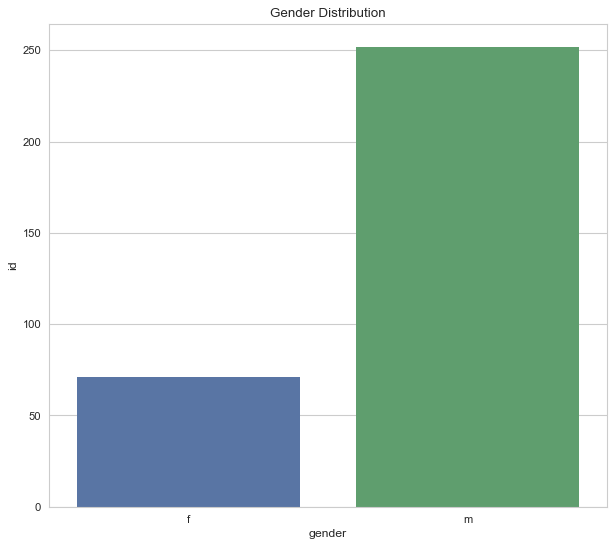

In [89]:
plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
sns.barplot(x="gender", y="id", data=gender_group)
plt.title("Gender Distribution")
plt.show()

In [91]:
script_with_new_id = pd.read_sql_query("""SELECT CASE WHEN INSTR(CAST(character_id AS VARCHAR),'.')>0 THEN SUBSTR(character_id ,1, INSTR(CAST(character_id AS VARCHAR),'.')-1)
                                                 ELSE character_id END as new_id,
                                                 CASE WHEN INSTR(CAST(location_id AS VARCHAR),'.')>0 THEN SUBSTR(location_id ,1, INSTR(CAST(location_id AS VARCHAR),'.')-1)
                                                 ELSE location_id END as new_loc_id,
                                                 *
                                          FROM script""", conn)

In [92]:
script_with_new_id.to_sql("script", conn, index = False, if_exists = "replace")

In [93]:
pd.read_sql_query("""SELECT gender, COUNT(*)
                     FROM (SELECT a.new_id, 
                            a.episode_id,
                            b.gender
                     FROM script a
                     LEFT JOIN (SELECT id, gender FROM characters) b
                     ON a.new_id = b.id)
                     GROUP BY gender""", conn)

,gender,COUNT(*)
0,None,39809
1,f,31212
2,m,87227


In [94]:
(31212+87227)/(31212+87227+39809)

0.7484391587887367

A total of 6722 characters were included in the character list. Only 323 characters were assigned a gender, and they were mostly male (78%). Characters with gender accounted for about 75% of the lines. 

In [95]:
top_10_lines = pd.read_sql_query("""SELECT new_id, name, gender, lines
                     FROM (SELECT new_id, count(id) AS lines 
                     FROM script 
                     WHERE new_id IS NOT NULL
                     GROUP BY new_id 
                     ORDER BY lines DESC) a
                     LEFT JOIN (SELECT id, name, gender FROM characters) b
                     ON a.new_id = b.id
                     LIMIT 10""", conn)

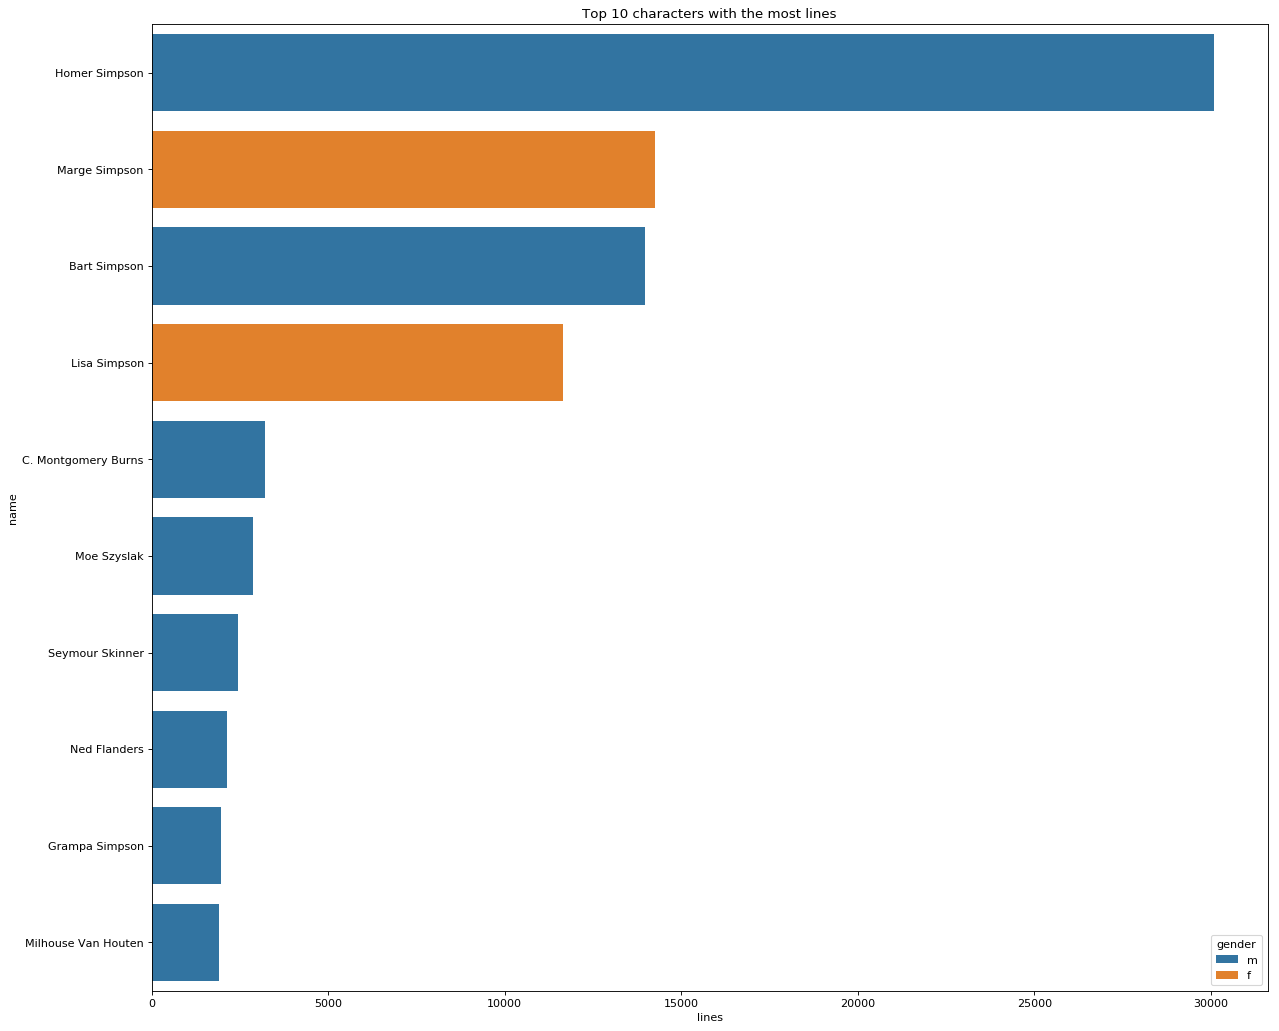

In [96]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.reset_defaults()
sns.barplot(x="lines", y="name", data=top_10_lines, orient= 'h', hue = "gender", dodge= False)
plt.title("Top 10 characters with the most lines")
plt.show()

In [97]:
pd.read_sql_query("""SELECT * FROM episodes LIMIT 1""", conn)

,id,title,original_air_date,production_code,season,number_in_season,number_in_series,us_viewers_in_millions,views,imdb_rating,imdb_votes,image_url,video_url
0,10,Homer's Night Out,1990-03-25,7G10,1,10,10,30.3,50816.0,7.4,1511.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/275197507879


In [98]:
pd.read_sql_query("""SELECT season, id, number_in_season, number_in_series
                     FROM episodes
                     WHERE id = 500""", conn)

,season,id,number_in_season,number_in_series
0,23,500,14,500


In [99]:
pd.read_sql_query("""SELECT MIN(episode_id), MAX(episode_id) FROM script""", conn)

,MIN(episode_id),MAX(episode_id)
0,1,568


In [218]:
# calculating the number of lines by each of the member of the simpson family
line_len = pd.read_sql_query("""SELECT episode_id,  SUM(CASE WHEN new_id = '2' THEN 1 ELSE 0 END) AS homer_lines,
                            SUM(CASE WHEN new_id = '1' THEN 1 ELSE 0 END) AS marge_lines,
                            SUM(CASE WHEN new_id = '8' THEN 1 ELSE 0 END) AS bart_lines,
                            SUM(CASE WHEN new_id = '9' THEN 1 ELSE 0 END) AS lisa_lines,
                            SUM(CASE WHEN new_id = '2' THEN word_count ELSE 0 END) AS homer_len,
                            SUM(CASE WHEN new_id = '1' THEN word_count ELSE 0 END) AS marge_len,
                            SUM(CASE WHEN new_id = '8' THEN word_count ELSE 0 END) AS bart_len,
                            SUM(CASE WHEN new_id = '9' THEN word_count ELSE 0 END) AS lisa_len,
                            COUNT(*) AS total, 
                            SUM(word_count) AS total_len
                     FROM script
                     GROUP BY episode_id""", conn)

In [220]:
# calculate the percentage of lines for each characters
line_len["homer_perc"] = round(line_len["homer_lines"]/line_len["total"]*100,2)
line_len["marge_perc"] = round(line_len["marge_lines"]/line_len["total"]*100,2)
line_len["bart_perc"] = round(line_len["bart_lines"]/line_len["total"]*100,2)
line_len["lisa_perc"] = round(line_len["lisa_lines"]/line_len["total"]*100,2)

In [222]:
# finding out who has the most lines in each episode
line_len["max_perc"] = line_len[["homer_perc","marge_perc","bart_perc","lisa_perc"]].apply(lambda x: max(x), axis = 1)

In [223]:
def compare(df):
    if df["max_perc"] == df["homer_perc"]:
        return "homer"
    elif df["max_perc"] == df["marge_perc"]:
        return "marge"
    elif df["max_perc"] == df["lisa_perc"]:
        return "lisa"
    elif df["max_perc"] == df["bart_perc"]:
        return "bart"

In [224]:
line_len["featuring"] = line_len.apply(lambda x: compare(x), axis = 1)

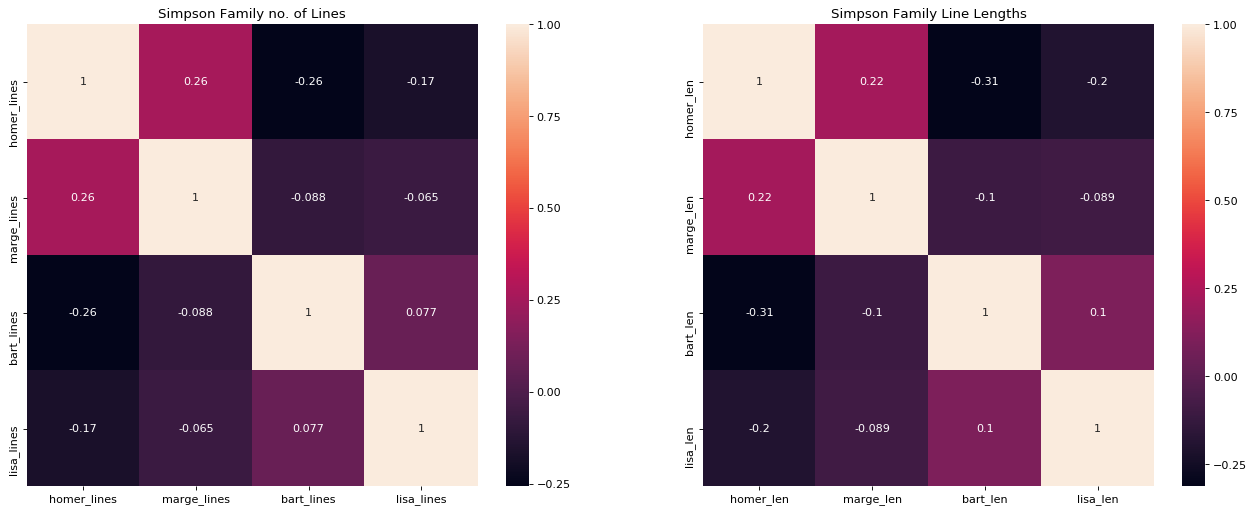

In [225]:
plt.figure(figsize=(20, 7.5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
sns.heatmap(line_len[["homer_lines","marge_lines","bart_lines","lisa_lines"]].corr(), annot=True)
plt.title("Simpson Family no. of Lines")
plt.subplot(1,2,2)
sns.heatmap(line_len[["homer_len","marge_len","bart_len", "lisa_len"]].corr(), annot=True)
plt.title("Simpson Family Line Lengths")
plt.show()

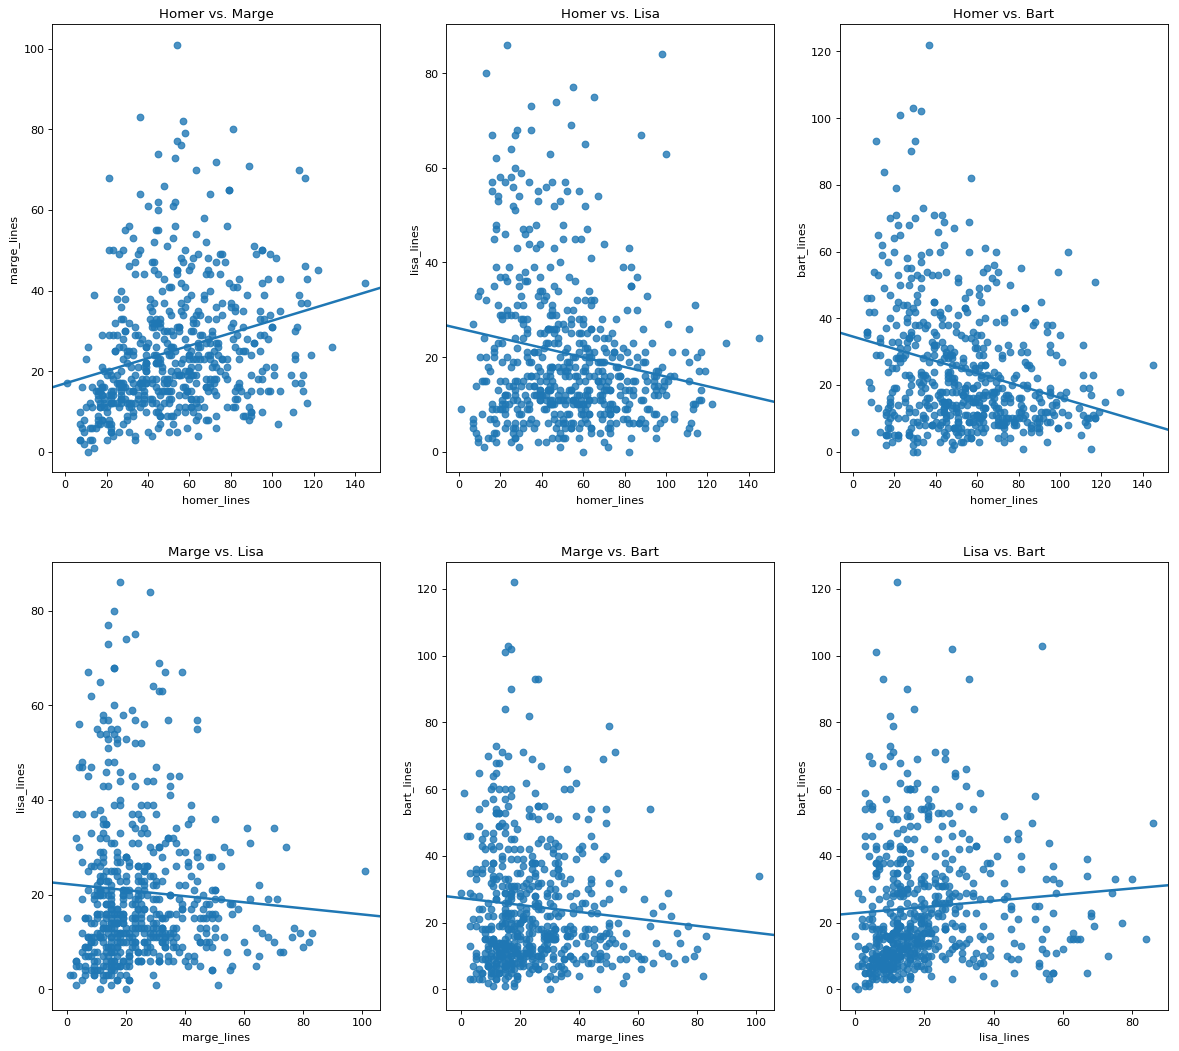

In [226]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,3,1)
sns.regplot(x = "homer_lines", y = "marge_lines", data = line_len, ci = False)
plt.title("Homer vs. Marge")
plt.subplot(2,3,2)
sns.regplot(x = "homer_lines", y = "lisa_lines", data = line_len, ci = False)
plt.title("Homer vs. Lisa")
plt.subplot(2,3,3)
sns.regplot(x = "homer_lines", y = "bart_lines", data = line_len, ci = False)
plt.title("Homer vs. Bart")
plt.subplot(2,3,4)
sns.regplot(x = "marge_lines", y = "lisa_lines", data = line_len, ci = False)
plt.title("Marge vs. Lisa")
plt.subplot(2,3,5)
sns.regplot(x = "marge_lines", y = "bart_lines", data = line_len, ci = False)
plt.title("Marge vs. Bart")
plt.subplot(2,3,6)
sns.regplot(x = "lisa_lines", y = "bart_lines", data = line_len, ci = False)
plt.title("Lisa vs. Bart")
plt.show()

In [108]:
# parent pair - homer + marge, children pair - lisa + bart. if the parent pair had more lines than the children pair
# I consider the episode to be featuring the parents. female_key = lisa + marge, male_ key = bart + homer. If an 
# episodes had more combined lines from the female_key, I considered this episode to feature the mother daughtor pair,
# and vice versa.
line_len["parent"] = line_len["homer_lines"] + line_len["marge_lines"]
line_len["children"] = line_len["bart_lines"] + line_len["lisa_lines"]
line_len["parent_feature"] = line_len["parent"] > line_len["children"]
line_len["female_key"] = line_len["marge_lines"] + line_len["lisa_lines"]
line_len["male_key"] = line_len["homer_lines"] + line_len["bart_lines"]
line_len["female_feature"] = line_len["female_key"] > line_len["male_key"]

In [109]:
line_len["parent_feature"].value_counts()

True     416
False    148
Name: parent_feature, dtype: int64

In [110]:
line_len["female_feature"].value_counts()

False    466
True      98
Name: female_feature, dtype: int64

In [111]:
line_len.to_sql("line_len", conn, index = False, if_exists='replace')

Homer had the most lines, and followed by all members of the Simpson family. No. of lines for Marge and Homer were weakly positively correlated with each other (p = 0.26), and the same positive correlation was found in the number of lines between Bart and Lisa. This suggests potential grouping between parent interaction and children interaction. Out of the 564 episodes that have scripts avaliable, 422 (75%) were more heavily focused on Homer and Marge, and only about 25% of the episodes focused on Bart and Lisa. However, only 98 episodes featured Lisa and Marge more than Bart and Homer.

In [112]:
# calculating per_female - percentage of lines that belonged to a female character
gender = pd.read_sql_query("""SELECT episode_id, SUM(CASE WHEN gender = 'm' THEN 1 ELSE 0 END) AS male_no, 
                     SUM(CASE WHEN gender = 'f' THEN 1 ELSE 0 END) AS female_no, 
                     COUNT(*) AS total_line,
                     ROUND(SUM(CASE WHEN gender = 'f' THEN 1 ELSE 0 END)/CAST(COUNT(*) AS FLOAT),2)*100 AS per_female
                     FROM(SELECT a.episode_id, a.new_id, b.gender
                     FROM (SELECT episode_id, new_id FROM script) a
                     LEFT JOIN (SELECT id, gender FROM characters) b
                     ON a.new_id = b.id)
                     GROUP BY episode_id""", conn)

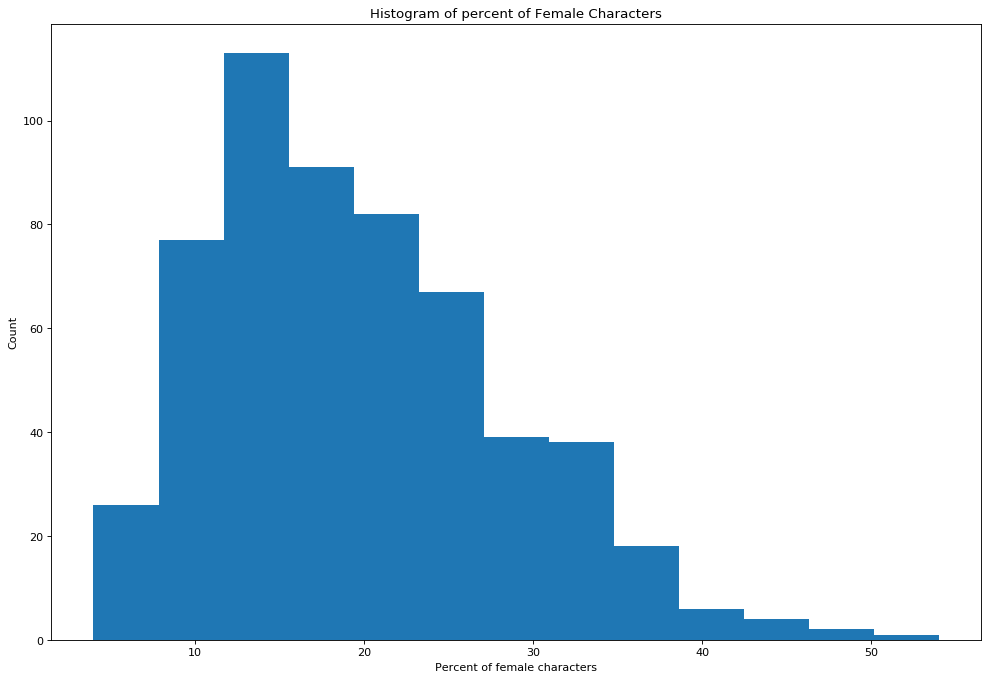

In [113]:
plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(x = gender["per_female"], bins = 13)
plt.xlabel("Percent of female characters")
plt.ylabel("Count")
plt.title("Histogram of percent of Female Characters")
plt.show()

In [114]:
gender.to_sql("gender", conn, index=False, if_exists = 'replace')

On average most episodes had 20% of female characters. The distribution is highly right-skewed.

In [115]:
total = pd.read_sql_query("""SELECT *
                     FROM (SELECT a.episode_id, a.male_no, a.female_no, a.total_line, a.per_female, b.season, 
                            b.number_in_season, b.us_viewers_in_millions, b.imdb_rating
                     FROM gender a
                     LEFT JOIN (SELECT id, season, number_in_season, us_viewers_in_millions, imdb_rating
                     FROM episodes) b
                     ON a.episode_id = b.id) c
                     LEFT JOIN (SELECT episode_id, homer_lines, marge_lines, bart_lines, lisa_lines, total, 
                                       homer_perc, marge_perc, bart_perc, lisa_perc, featuring, parent_feature,
                                       female_feature
                                FROM line_len) d
                     ON c.episode_id = d.episode_id""", conn)

In [198]:
total["featuring"].value_counts()

homer    368
bart      90
lisa      62
marge     44
Name: featuring, dtype: int64

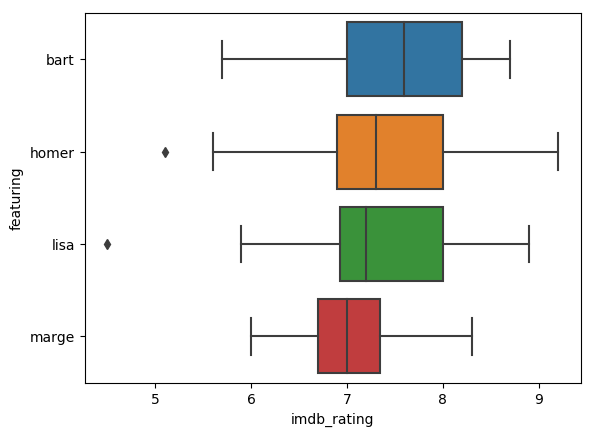

In [216]:
sns.boxplot(total["imdb_rating"], total["featuring"],order=["bart","homer","lisa","marge"])
plt.show()

In [214]:
def yes_no(x):
    if x == 1:
        return "Yes"
    else:
        return "No"
total["parent_yes"] = total["parent_feature"].apply(lambda x : yes_no(x))
total["female_yes"] = total["female_feature"].apply(lambda x: yes_no(x))

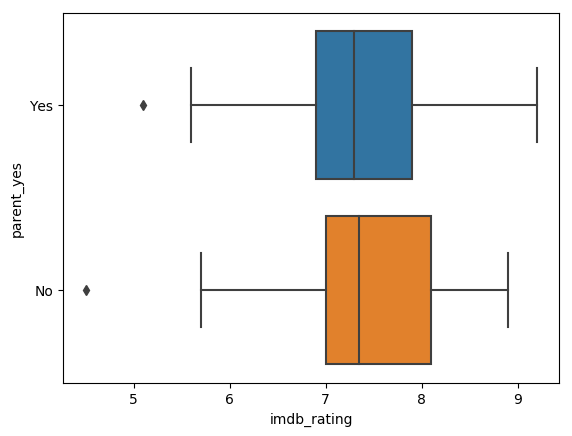

In [213]:
sns.boxplot(total["imdb_rating"], total["parent_yes"])
plt.show()

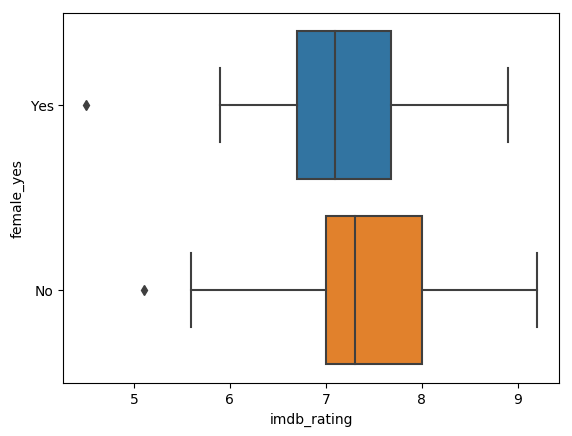

In [217]:
sns.boxplot(total["imdb_rating"], total["female_yes"], order = ["Yes","No"])
plt.show()

In [117]:
featuring = total.pivot_table(values = "male_no", index = "season", columns = "featuring", aggfunc = "count").fillna(0).reset_index()

In [118]:
featuring_prop = pd.merge(featuring, graphing[["season", "episodes"]], how = "inner", on = "season")
featuring_prop["bart_prop"] = round(featuring_prop["bart"]/featuring_prop["episodes"]*100, 2)
featuring_prop["homer_prop"] = round(featuring_prop["homer"]/featuring_prop["episodes"]*100, 2)
featuring_prop["lisa_prop"] = round(featuring_prop["lisa"]/featuring_prop["episodes"]*100, 2)
featuring_prop["marge_prop"] = round(featuring_prop["marge"]/featuring_prop["episodes"]*100, 2)

In [126]:
pd.read_sql_query("""SELECT MAX(episode_id), MIN(episode_id) FROM script""", conn)

,MAX(episode_id),MIN(episode_id)
0,568,1


In [134]:
pd.read_sql_query("""SELECT * FROM episodes WHERE number_in_series = 568""", conn)
# the script only contains data up to season 26 number 16 - exclude season 26 in the graphs

,id,title,original_air_date,production_code,season,number_in_season,number_in_series,us_viewers_in_millions,views,imdb_rating,imdb_votes,image_url,video_url
0,568,Sky Police,2015-03-08,TABF09,26,16,568,3.79,43023.0,6.9,377.0,http://static-media.fxx.com/img/FX_Networks_-_...,http://www.simpsonsworld.com/video/410018371522


In [135]:
featuring_prop_25 = featuring_prop[featuring_prop["season"] < 26]

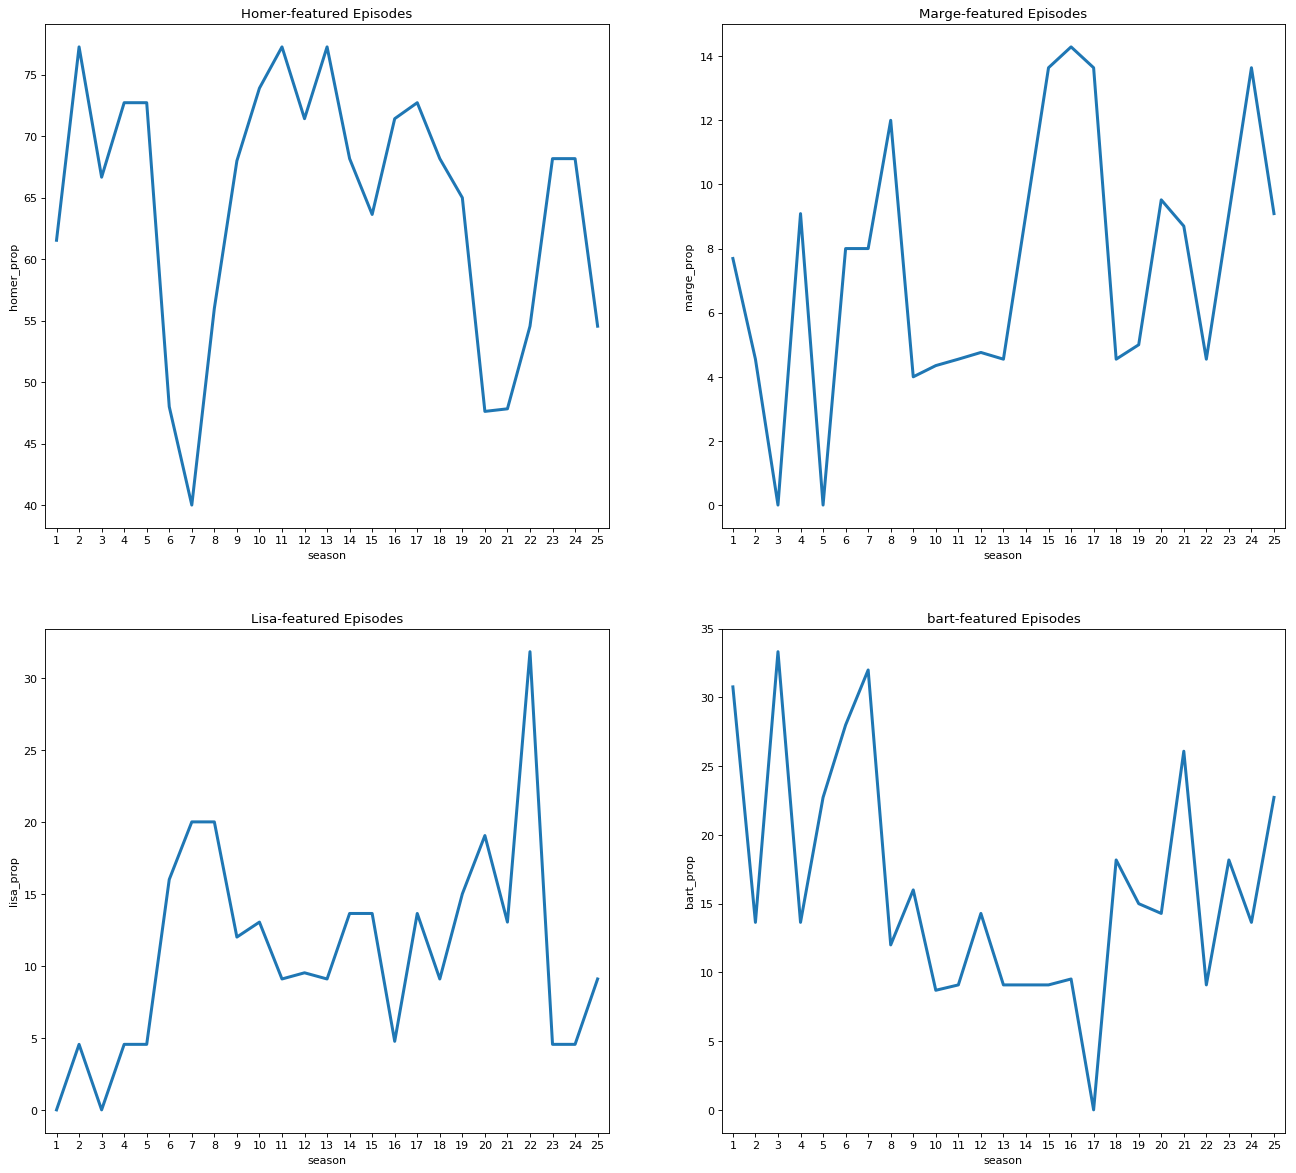

In [136]:
plt.figure(figsize=(20, 18), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,2,1)
sns.pointplot(x = "season", y = "homer_prop", data = featuring_prop_25, markers="")
plt.title("Homer-featured Episodes")
plt.subplot(2,2,2)
sns.pointplot(x = "season", y = "marge_prop", data = featuring_prop_25, markers="")
plt.title("Marge-featured Episodes")
plt.subplot(2,2,3)
sns.pointplot(x = "season", y = "lisa_prop", data = featuring_prop_25, markers="")
plt.title("Lisa-featured Episodes")
plt.subplot(2,2,4)
sns.pointplot(x = "season", y = "bart_prop", data = featuring_prop_25, markers="")
plt.title("bart-featured Episodes")
plt.show()

In [185]:
feature_graph = featuring_prop_25[["season", "homer_prop","marge_prop","bart_prop","lisa_prop"]]
feature_graph = feature_graph.set_index("season")

season,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
homer_prop,61.54,77.27,66.67,72.73,72.73,48.0,40.0,56.0,68.0,73.91,77.27,71.43,77.27,68.18,63.64,71.43,72.73,68.18,65.0,47.62,47.83,54.55,68.18,68.18,54.55
marge_prop,7.69,4.55,0.00,9.09,0.00,8.0,8.0,12.0,4.0,4.35,4.55,4.76,4.55,9.09,13.64,14.29,13.64,4.55,5.0,9.52,8.70,4.55,9.09,13.64,9.09
bart_prop,30.77,13.64,33.33,13.64,22.73,28.0,32.0,12.0,16.0,8.70,9.09,14.29,9.09,9.09,9.09,9.52,0.00,18.18,15.0,14.29,26.09,9.09,18.18,13.64,22.73
lisa_prop,0.00,4.55,0.00,4.55,4.55,16.0,20.0,20.0,12.0,13.04,9.09,9.52,9.09,13.64,13.64,4.76,13.64,9.09,15.0,19.05,13.04,31.82,4.55,4.55,9.09


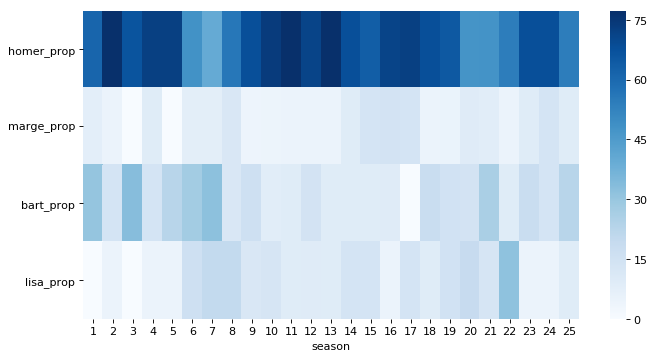

In [192]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(feature_graph.T, cmap="Blues")
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

In [143]:
season_info = total[["season","us_viewers_in_millions","imdb_rating"]].groupby("season").agg("mean").reset_index()

In [147]:
all_season = pd.merge(featuring_prop_25, season_info, how="inner", on = "season")

In [148]:
all_season.head(4)

,season,bart,homer,lisa,marge,episodes,bart_prop,homer_prop,lisa_prop,marge_prop,us_viewers_in_millions,imdb_rating
0,1,4.0,8.0,0.0,1.0,13,30.77,61.54,0.00,7.69,27.807692,7.807692
1,2,3.0,17.0,1.0,1.0,22,13.64,77.27,4.55,4.55,24.404545,8.040909
2,3,8.0,16.0,0.0,0.0,24,33.33,66.67,0.00,0.00,21.766667,8.154167
3,4,3.0,16.0,1.0,2.0,22,13.64,72.73,4.55,9.09,22.395455,8.268182


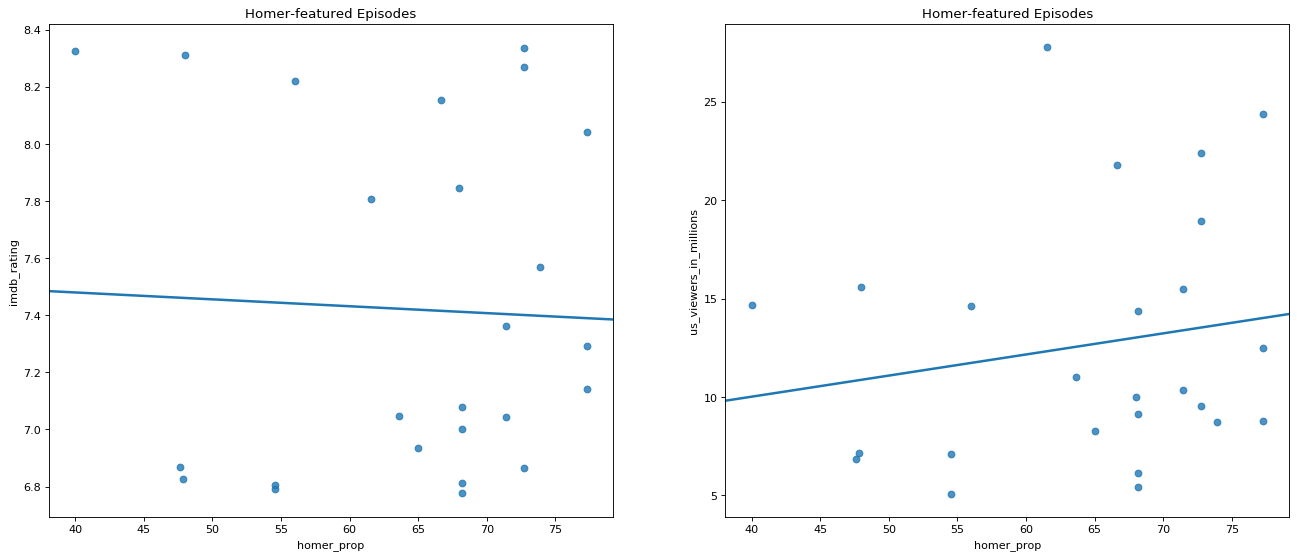

In [159]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
sns.regplot(x = "homer_prop", y = "imdb_rating", data = all_season, ci= False)
plt.title("Homer-featured Episodes")
plt.subplot(1,2,2)
sns.regplot(x = "homer_prop", y = "us_viewers_in_millions", data = all_season, ci = False)
plt.title("Homer-featured Episodes")
plt.show()

In [160]:
all_season[["homer_prop","us_viewers_in_millions","imdb_rating"]].corr()

,homer_prop,us_viewers_in_millions,imdb_rating
homer_prop,1.000000,0.179994,-0.042689
us_viewers_in_millions,0.179994,1.000000,0.757780
imdb_rating,-0.042689,0.757780,1.000000


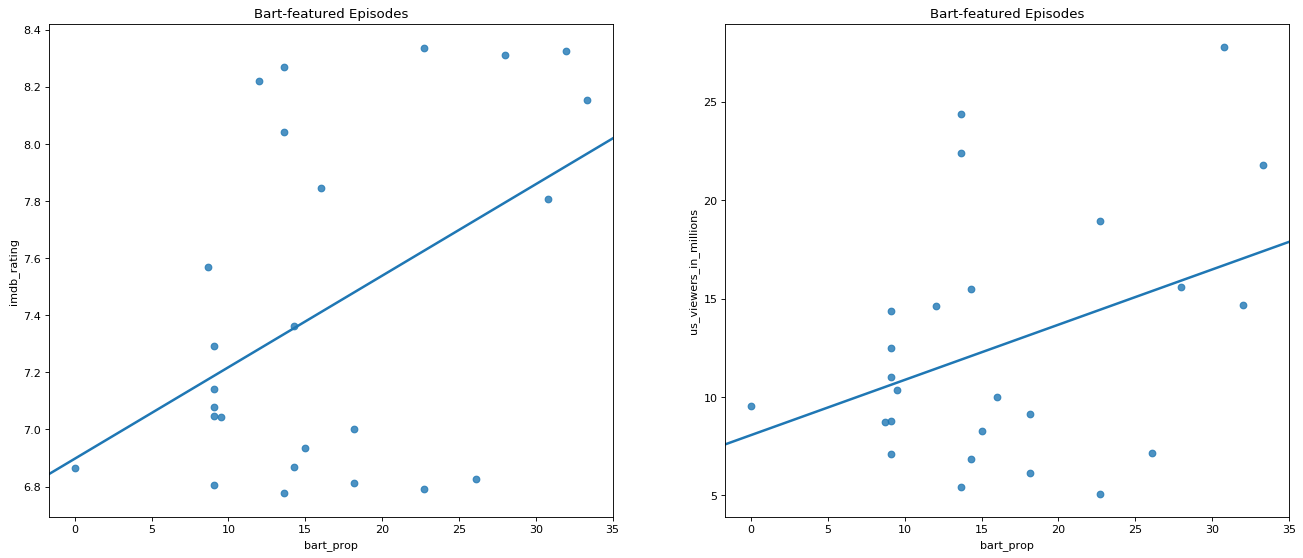

In [158]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
sns.regplot(x = "bart_prop", y = "imdb_rating", data = all_season, ci= False)
plt.title("Bart-featured Episodes")
plt.subplot(1,2,2)
sns.regplot(x = "bart_prop", y = "us_viewers_in_millions", data = all_season, ci = False)
plt.title("Bart-featured Episodes")
plt.show()

In [162]:
all_season[["bart_prop","us_viewers_in_millions","imdb_rating"]].corr()

,bart_prop,us_viewers_in_millions,imdb_rating
bart_prop,1.000000,0.381116,0.458865
us_viewers_in_millions,0.381116,1.000000,0.757780
imdb_rating,0.458865,0.757780,1.000000


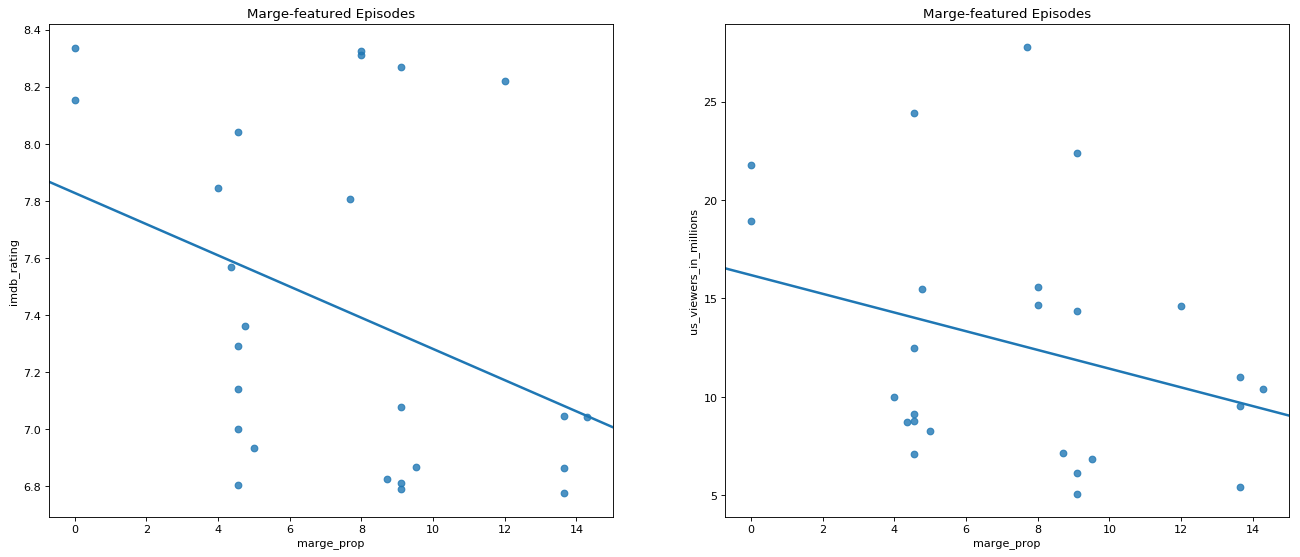

In [163]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
sns.regplot(x = "marge_prop", y = "imdb_rating", data = all_season, ci= False)
plt.title("Marge-featured Episodes")
plt.subplot(1,2,2)
sns.regplot(x = "marge_prop", y = "us_viewers_in_millions", data = all_season, ci = False)
plt.title("Marge-featured Episodes")
plt.show()

In [165]:
all_season[["marge_prop","us_viewers_in_millions","imdb_rating"]].corr()

,marge_prop,us_viewers_in_millions,imdb_rating
marge_prop,1.000000,-0.304334,-0.368492
us_viewers_in_millions,-0.304334,1.000000,0.757780
imdb_rating,-0.368492,0.757780,1.000000


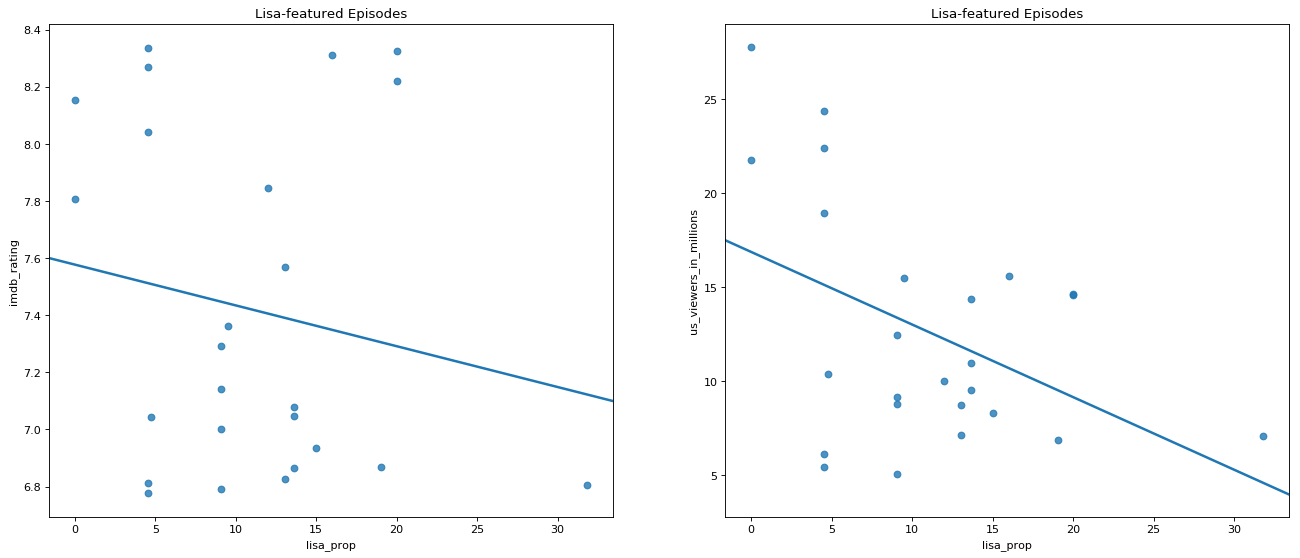

In [166]:
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
sns.regplot(x = "lisa_prop", y = "imdb_rating", data = all_season, ci= False)
plt.title("Lisa-featured Episodes")
plt.subplot(1,2,2)
sns.regplot(x = "lisa_prop", y = "us_viewers_in_millions", data = all_season, ci = False)
plt.title("Lisa-featured Episodes")
plt.show()

In [167]:
all_season[["lisa_prop","us_viewers_in_millions","imdb_rating"]].corr()

,lisa_prop,us_viewers_in_millions,imdb_rating
lisa_prop,1.000000,-0.441725,-0.17227
us_viewers_in_millions,-0.441725,1.000000,0.75778
imdb_rating,-0.172270,0.757780,1.00000


In [102]:
top_10_locations = pd.read_sql_query("""SELECT a.new_loc_id, a.line_counts, b.normalized_name
                     FROM (SELECT new_loc_id, 
                                  COUNT(new_id) AS line_counts
                     FROM script
                     GROUP BY new_loc_id
                     ORDER BY line_counts DESC) a 
                     LEFT JOIN locations b
                     ON a.new_loc_id = b.id
                     LIMIT 10""", conn)

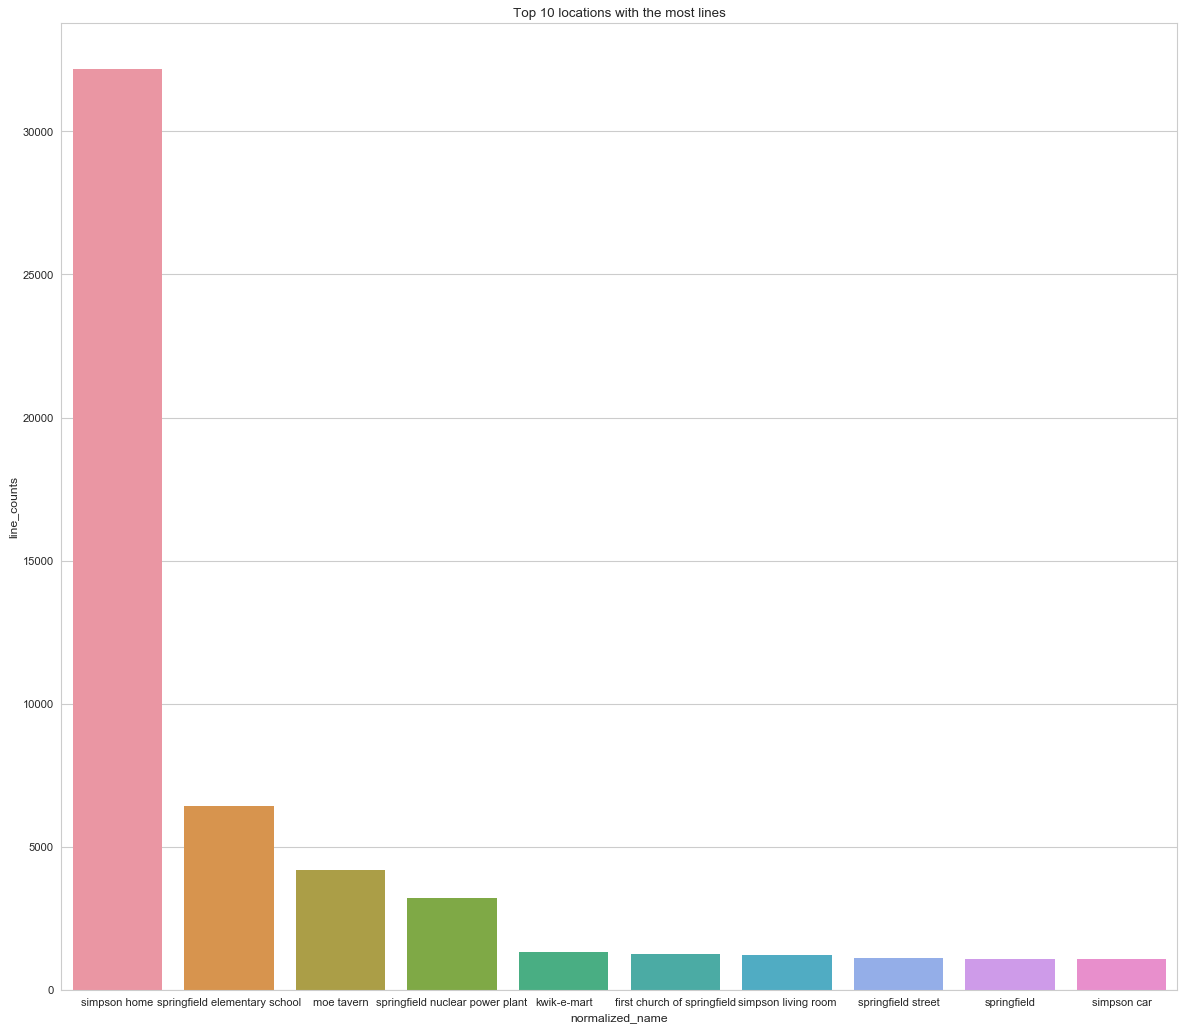

In [316]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.barplot(x="normalized_name", y="line_counts", data=top_10_locations)
plt.title("Top 10 locations with the most lines")
plt.show()

Most of the conversations occured at simpson home, the springfield elementary school, and moe's tavern